# <font color="orange"> Vision Transformer (ViT) from Scratch

This notebook implements a **Vision Transformer (ViT)** model from scratch using PyTorch. The ViT architecture is introduced in the machine learning research paper titled "[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)" by Dosovitskiy et al., 2021. The goal is to understand the core components of a ViT and train it on a small dataset.

The notebook covers the following steps:
1. **Setup**: Installs necessary libraries and builds required functions for a classification task.
2. **Data Loading**: Downloads the dataset from a given url
2. **Model Architecture**: Defines the key components of the ViT model, including Patch Embedding, Multihead Self-Attention, MLP Block, Transformer Encoder, and the main ViT class.
3. **Training**: Sets up the optimizer and loss function, and trains the ViT model on the downloaded dataset.
4. **Results**: Visualizes the training and testing loss and accuracy curves as well as making predictions on some images.

Thank you to everyone involved in the *Zero to Mastery Learn PyTorch for Deep Learning* course available at https://www.learnpytorch.io/.

Let's start with the setup:

# 1. Setup

## 1-1. Libraries Installation and Upgrade

In [1]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

  if torch.cuda.is_available():
    device = "cuda"
    cuda_ver = torch.version.cuda
    print(f"PyTorch uses CUDA version: {cuda_ver}")
  else:
    device = "cpu"
    print("PyTorch cannot use CUDA.")

except:
  print("[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu126
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

  if torch.cuda.is_available():
    device = "cuda"
    cuda_ver = torch.version.cuda
    print(f"PyTorch uses CUDA version: {cuda_ver}")
  else:
    device = "cpu"
    print("PyTorch cannot use CUDA.")

torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126
PyTorch uses CUDA version: 12.6


In [2]:
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import time

try:
  from torchinfo import summary
except:
  print("[INFO] Could not find torchinfo ... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

* The `-U` flag in the pip install command stands for `--upgrade`. It tells pip to upgrade the specified packages to the latest available version if they are already installed, rather than just installing them if they aren't present.

* at `!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu125`, "Nightly versions" refer to software builds that are compiled and released automatically every night. These versions represent the absolute latest state of the software's development, including the most recent bug fixes, features, and improvements. They are primarily used by developers and advanced users who want to test the very newest changes and are comfortable with the potential for instability that comes with using cutting-edge software. They are not typically recommended for production environments where stability is critical.

* The nightly builds of PyTorch are compiled with support for specific CUDA versions. By activating the GPU and checking its CUDA version using !nvcc --version (or ideally, checking with torch.version.cuda after importing torch), you can ensure you install the nightly build that is compatible with the CUDA version available in your Colab environment. This is why the URL for the nightly build includes the CUDA version, like `https://download.pytorch.org/whl/nightly/cu125`.

* The `-q` flag in the `pip install -q torchinfo` command stands for `--quiet`. It tells pip to produce less output during the installation process. This is useful when you don't need to see the detailed progress of the installation and want a cleaner output.










## 1-2. Building the Required Functions

In [3]:
from pathlib import Path

folder = "required_functions"
folder_path = Path(folder)

if folder_path.is_dir():
  print(f"[INFO] {folder} directory already exists")

else:
  print(f"Did not find {folder} directory, creating one ...")
  folder_path.mkdir(parents=True, exist_ok=True)

[INFO] required_functions directory already exists


The following cells use the `%%writefile` magic command to create Python files in the `required_functions` directory.

### 1-2-1. `download_data.py`
The file `download_data.py` contains a function `download_data` that downloads a zipped dataset from a specified source URL, unzips it to a destination directory, and optionally removes the downloaded zip file. This function is used to easily get the dataset needed for the notebook.

In [4]:
%%writefile required_functions/download_data.py
from pathlib import Path
import zipfile
import os
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool=True) -> Path:
                  """ Download a zipped dataset from source and unzips to destination """
                  data_path = Path("data/")
                  image_path = data_path / destination

                  if image_path.is_dir():
                    print(f"[INFO] {image_path} directory exists, skipping download.")

                  else:
                    print(f"Did not find {image_path} directory, creating one ...")
                    image_path.mkdir(parents=True, exist_ok=True)

                    target_file = Path(source).name
                    with open(data_path / target_file, "wb") as f:
                      request = requests.get(source)
                      print(f"[INFO] Downloading {target_file} from {source} ...")
                      f.write(request.content)

                    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
                      print(f"[INFO] Unzipping {target_file} data ...")
                      zip_ref.extractall(image_path)

                    if remove_source:
                      os.remove(data_path / target_file)

                  return image_path

Overwriting required_functions/download_data.py


### 1-2-2. `data_setup.py`
The `data_setup.py` file contains a function `create_dataloaders` that handles the loading and preparation of the image dataset, including creating training and testing DataLoaders and getting the class names.

In [5]:
%%writefile required_functions/data_setup.py
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    image_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS):
  train_data = datasets.ImageFolder(train_dir, transform=image_transform)
  test_data = datasets.ImageFolder(test_dir, transform=image_transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=True)
  test_dataloader = DataLoader(test_data,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers,
                               pin_memory=True)

  return train_dataloader, test_dataloader, class_names

Overwriting required_functions/data_setup.py


### 1-2-3. `engine.py`
The `engine.py` file contains functions for training and testing a PyTorch model:

> *   `train_step`: Performs a single training step (forward pass, loss calculation, backward pass, and optimizer step) for one epoch.
> *   `test_step`: Performs a single testing step (forward pass and loss calculation) for one epoch in inference mode.
> *   `train`: Orchestrates the training process over multiple epochs, calling `train_step` and `test_step` and storing the results.

In [6]:
%%writefile required_functions/engine.py
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

               """ Train for a single epoch """
               model.train() # put model in train mode

               train_loss, train_acc = 0, 0

               for batch, (X, y) in enumerate(dataloader):
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X) # 1. Forward pass

                loss = loss_fn(y_pred, y) # 2. Calculate loss
                train_loss += loss.item() # 2-1. Accumulate loss across all batches in an epoch

                optimizer.zero_grad() # 3. Optimizer zero grad

                loss.backward() # 4. Loss backward

                optimizer.step() # 5. Optimizer step

                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                train_acc += (y_pred_class == y).sum().item()/len(y_pred) # Calculate accuracy of one batch and accumulate it across all batches in an epoch

               train_loss = train_loss / len(dataloader) # Average loss per batch
               train_acc = train_acc / len(dataloader) # Average accuracy per batch

               return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

              """ Test for a single epoch """
              model.eval() # put model in eval mode

              test_loss, test_acc = 0, 0

              with torch.inference_mode():
                for batch, (X, y) in enumerate(dataloader):
                  X = X.to(device)
                  y = y.to(device)

                  y_pred = model(X) # 1. Forward pass

                  loss = loss_fn(y_pred, y) # 2. Calculate loss
                  test_loss += loss.item() # 2-1. Accumulate loss across all batches in an epoch


                  y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                  test_acc += (y_pred_class == y).sum().item()/len(y_pred_class) # Calculate accuracy of one batch and accumulate it across all batches in an epoch

              test_loss = test_loss / len(dataloader) # Average loss per batch
              test_acc = test_acc / len(dataloader) # Average accuracy per batch

              return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, list]:

          """ Train and tests a model """

          results = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

          for epoch in tqdm(range(epochs)):
            train_loss, train_acc = train_step(model=model,
                                               dataloader=train_dataloader,
                                               loss_fn=loss_fn,
                                               optimizer=optimizer,
                                               device=device)
            test_loss, test_acc = test_step(model=model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)

            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_acc: {test_acc:.4f}" )

            results["train_loss"].append(train_loss)
            results["test_loss"].append(test_loss)
            results["train_acc"].append(train_acc)
            results["test_acc"].append(test_acc)

          return results

Overwriting required_functions/engine.py


### 1-2-4. `plot_loss_curves.py`
The `plot_loss_curves.py` file contains a function `plot_loss_curves` that takes the training results (loss and accuracy) and visualizes them as plots. This helps in understanding how the model performed during training.

In [7]:
%%writefile required_functions/plot_loss_curves.py
import matplotlib.pyplot as plt

def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2, 2)
  plt.plot(epochs, train_acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

Overwriting required_functions/plot_loss_curves.py


### 1-2-5. `pred_and_plot.py`

In [8]:
%%writefile required_functions/prediction.py
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms

from typing import List, Tuple

from PIL import Image

def pred_and_plot(model: torch.nn.Module,
                  img_path: str,
                  class_names: List[str],
                  img_size: Tuple[int, int]=(224, 224),
                  transform: torchvision.transforms=None,
                  device: torch.device="cuda" if torch.cuda.is_available else "cpu"):
  img = Image.open(img_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(img_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )])
  model.to(device)
  # turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0) # model requires samples in [batch_size, color_channels, height, width]
    pred_logit = model(transformed_image.to(device))

  pred_prob = torch.softmax(pred_logit, dim=1) # Convert logits -> prediction probabilities
  pred_label = torch.argmax(pred_prob, dim=1) # Convert prediction probabilities -> prediction labels

  plt.figure()
  plt.imshow(img)
  plt.title(f"Predicted label: {class_names[pred_label]} | Prob: {pred_prob.max():.3f}")
  plt.axis(False)

Overwriting required_functions/prediction.py


### 1-2-6. `set_seeds.py`
The `set_seeds.py` file contains a function `set_seeds` that sets random seeds for both CPU and CUDA operations in PyTorch. This is important for reproducibility, ensuring that the results of your code are the same each time you run it with the same seed.

In [9]:
%%writefile required_functions/set_seeds.py
import torch
def set_seeds(seed: int=42):
  torch.manual_seed(seed) # for general torch operations
  torch.cuda.manual_seed(seed) # for CUDA torch operations

Overwriting required_functions/set_seeds.py


# 2. Data

In [10]:
from required_functions import data_setup, engine
from required_functions import set_seeds, download_data, plot_loss_curves, prediction

In [11]:
image_path = download_data.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [12]:
IMAGE_SIZE = 224 # Table 3 in the ViT paper
BATCH_SIZE = 32 # Lower than ViT paper but we intend to start small to run on Google Colab
COLOR_CHANNEL_SIZE = 3 # RGB images

manual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                 transforms.ToTensor()])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               image_transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

# 3. ViT-Base/16 Model Architecture

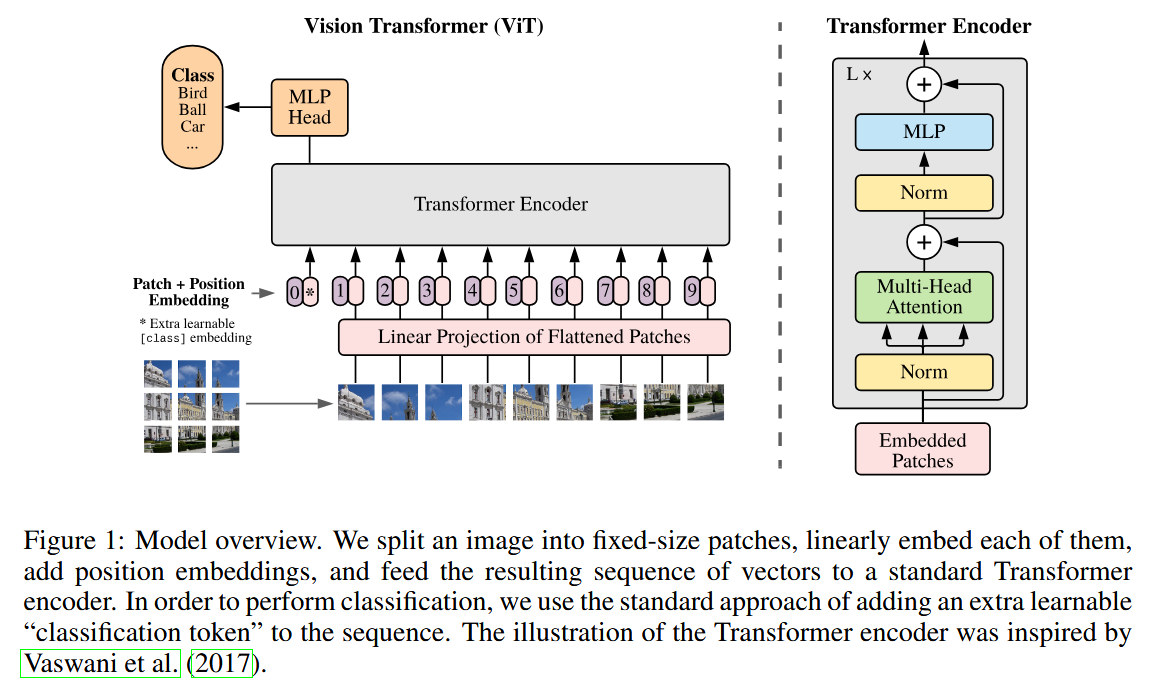

In [13]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patch_size = patch_size # Store patch_size as an instance variable

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):

    image_size = x.shape[-1]

    assert image_size % self.patch_size == 0, f"Input image size must {image_size} must be divisible by patch size {self.patch_size}"

    x_patched = self.patcher(x)

    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1) #[batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [14]:
class MultiheadSelfAttentionBlock(nn.Module):
  """Creatres a multi-head self-attention block (MSA Block)"""
  def __init__(self,
               embedding_dim: int=768, # Hidden size based on Table 1
               num_heads: int=12, # Heads from Table 1
               attn_dropout: float=0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [15]:
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron_block (MLP Block)"""
  """The MLP consists of two linear layers with a GELU activation function in between."""
  def __init__(self,
               embedding_dim: int= 768,
               mlp_size: int=3072,
               dropout: float=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout), # "Dropout, when used, is applied after every dense layer.."
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x



In [16]:
class TransformerEncoderBlock(nn.Module):
  """Creates a transformer encoder block (Transformer Encoder)"""
  def __init__(self,
               embedding_dim: int=768, # Hidden size from Table 1
               num_heads: int=12, # Heads from Table 1
               mlp_size: int=3072, # MLP size from Table 1
               mlp_dropout: float=0.1, # Dropout for dense layeres from Table 3
               attn_dropout: float=0): # Dropout for attention layers
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = x + self.msa_block(x)
    x = x + self.mlp_block(x)
    return x

In [17]:
class ViT(nn.Module):
  """Creates a Vision Transformer (ViT) architecture with ViT-Base hyperparameters"""
  def __init__(self,
               img_size: int=224,
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12,
               embedding_dim: int=768,
               mlp_size: int=3072,
               num_heads: int=12,
               attn_dropout: float=0,
               mlp_dropout: float=0.1,
               embedding_dropout: float=0.1,
               num_classes: int=1000):
    super().__init__()

    assert img_size % patch_size ==0, f"Image size ({img_size}) must be divisible by patch size ({patch_size})"

    self.num_patches = (img_size // patch_size) ** 2

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                        patch_size=patch_size,
                                        embedding_dim=embedding_dim)

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                      requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim),
                                         requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size=mlp_size,
                                                                      mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    self.classification_head = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                           nn.Linear(in_features=embedding_dim,
                                                     out_features=num_classes))
  def forward(self, x):

    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, 1, -1)

    x = self.patch_embedding(x)

    x = torch.cat((class_token, x), dim=1)

    x = self.position_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.classification_head(x[:, 0])

    return x

In [18]:
vit = ViT(num_classes=len(class_names))

summary(model=vit,
        input_size=(BATCH_SIZE, COLOR_CHANNEL_SIZE, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# 4. Training the Model

In [19]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = nn.CrossEntropyLoss()

set_seeds.set_seeds()

start_time = time.time()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device)
end_time = time.time()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.9956 | test_loss: 3.6213 | train_acc: 0.3125 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.0586 | test_loss: 1.6705 | train_acc: 0.3438 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1880 | test_loss: 1.6067 | train_acc: 0.4648 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2350 | test_loss: 1.3465 | train_acc: 0.3008 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1520 | test_loss: 1.2017 | train_acc: 0.2969 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1727 | test_loss: 1.2877 | train_acc: 0.2891 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2543 | test_loss: 1.2100 | train_acc: 0.2891 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1088 | test_loss: 1.2059 | train_acc: 0.3789 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1340 | test_loss: 1.0185 | train_acc: 0.4297 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2632 | test_loss: 1.4430 | train_acc: 0.2578 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.3255 | test_loss: 1.0831 | train_acc: 0.3008 | test_acc: 0.5417
Epoch: 12 | train_l

# 5. Results

## 5-1. Plot train and test loss and accuracy curves

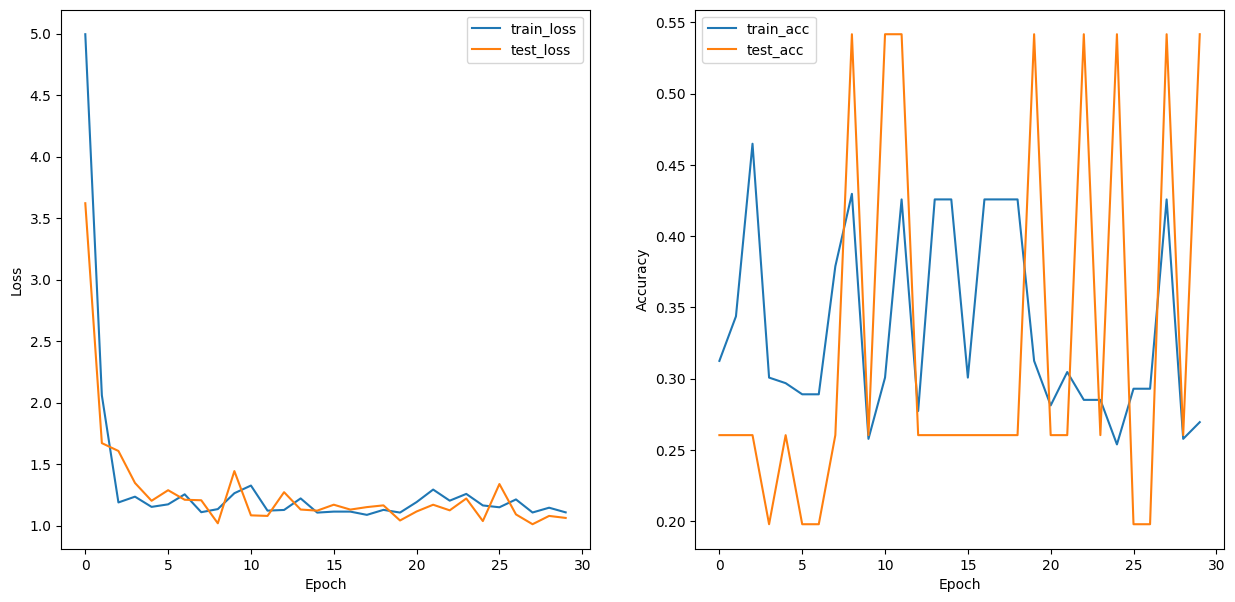

In [20]:
plot_loss_curves.plot_loss_curves(results)

The original ViT architecture achieves good results on several image classification benchmarks. However, our results (so far) aren't as good.

The original ViT paper uses a far larger amount of data than ours and a longer training schedule.


| Hyperparameter value | ViT Paper | Our implementation |
|---|---|---|
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 30 |
| Batch size | 4096 | 32 |
| Learning rate warmup | 10k steps (Table 3) | None |
| Learning rate decay | Linear/Cosine (Table 3) | None |
| Gradient clipping | Global norm 1 (Table 3) | None |


## 5-2. Make predictions
We will get a random list of 10 images from test dataset and make predictions on them.

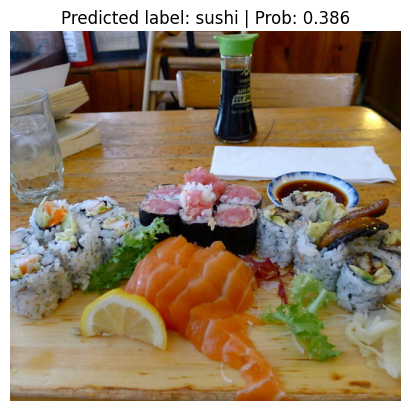

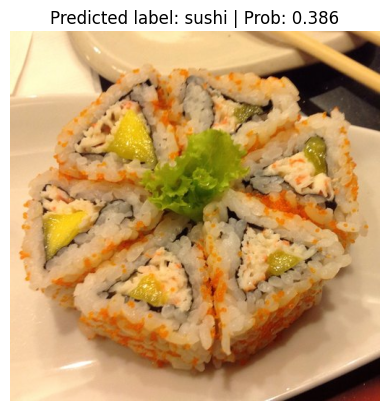

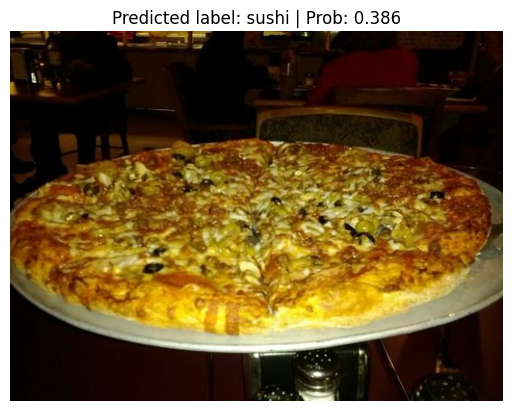

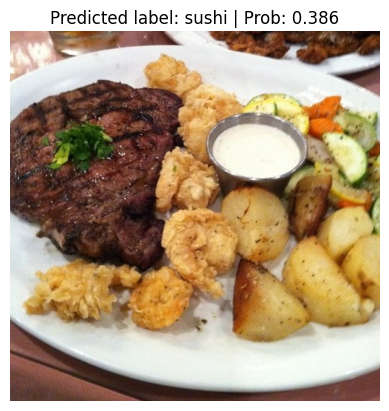

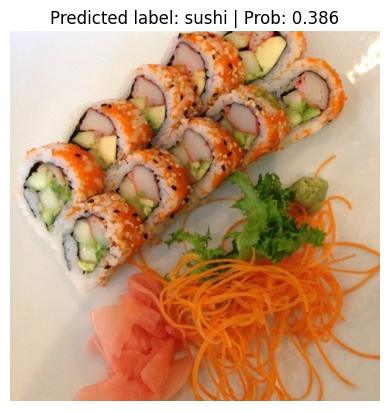

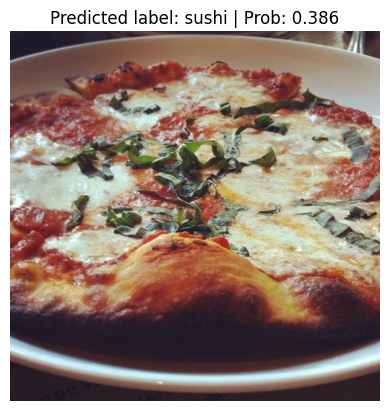

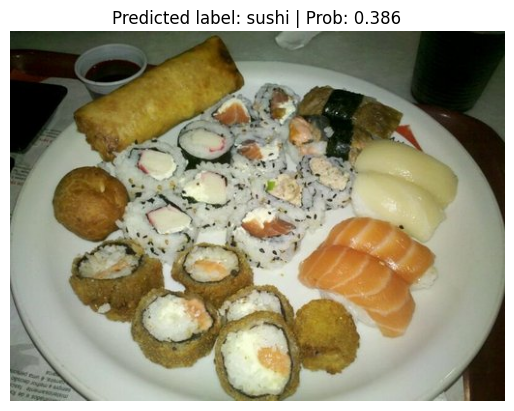

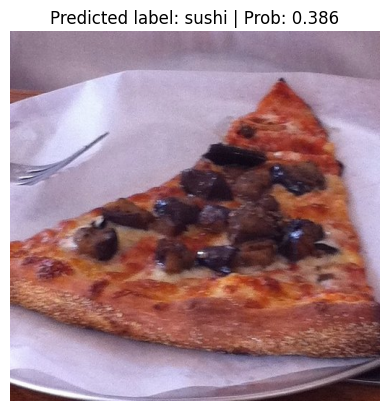

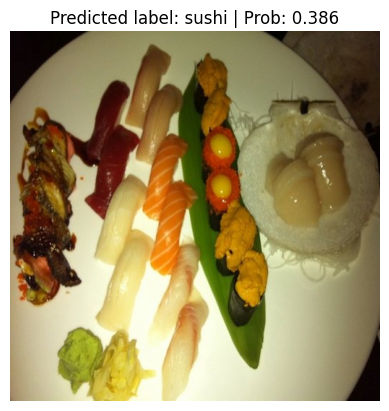

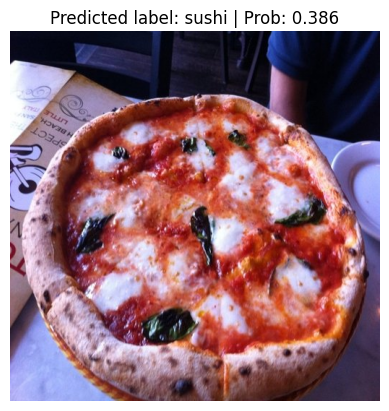

In [21]:
import random
n_samples = 10
all_test_path_list = list(Path(test_dir).glob("*/*.jpg"))
samples_test_path_list = random.sample(population=all_test_path_list,
                                      k=n_samples)
for path in samples_test_path_list:
  prediction.pred_and_plot(model=vit,
                           img_path=path,
                           class_names=class_names,
                           img_size=(224, 224),
                           transform=manual_transforms,
                           device=device)

Our model predicts all images as sushi :(

It seems our model is severely underfitting.

These results are likely because of the difference in data resources and training regime of our ViT model versus the ViT paper.

